In [2]:
import pandas as pd
import numpy as np
import joblib
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, roc_curve, accuracy_score)


In [3]:
csv_path = "merged_lexical_clean_2.csv"
df = pd.read_csv(csv_path)
print("Original shape:", df.shape)

# Drop duplicates by URL (if column exists)
if 'url' in df.columns:
    df = df.drop_duplicates(subset='url')
    print("After deduplication:", df.shape)

# Identify label column
label_candidates = [col for col in df.columns if col.lower() in {"label", "class", "target", "result"}]
assert label_candidates, "No label column found!"
LABEL = label_candidates[0]

# Prepare features
exclude_cols = [LABEL, "url", "URL", "website", "dataset_source"]
X = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number])  # only numeric features
y = df[LABEL].astype(int)

# Clean inf and NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print("Final features shape:", X.shape)


Original shape: (21430, 15)
Final features shape: (21430, 14)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (17144, 14) Test: (4286, 14)


In [5]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

pipe.fit(X_train, y_train)
print("Model trained successfully!")


Model trained successfully!


In [6]:
# Predict probabilities
test_probs = pipe.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= 0.5).astype(int)

# Basic metrics
auc = roc_auc_score(y_test, test_probs)
acc = accuracy_score(y_test, test_preds)
cm = confusion_matrix(y_test, test_preds)
report = classification_report(y_test, test_preds, output_dict=True)

print("AUC:", auc)
print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)


AUC: 0.8431252040033542
Accuracy: 0.757816145590294
Confusion Matrix:
 [[1657  486]
 [ 552 1591]]


Best F1 threshold: 0.3763789693112181


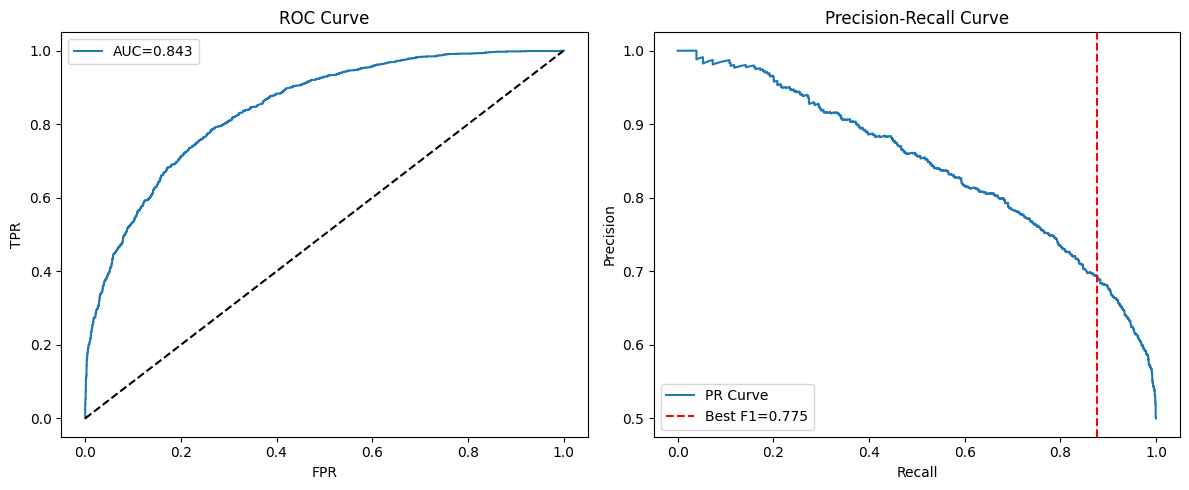

In [7]:
# Best threshold from PR curve
precisions, recalls, thresholds = precision_recall_curve(y_test, test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.argmax(f1_scores)
best_thr = thresholds[best_idx]
print("Best F1 threshold:", best_thr)

# Plot ROC & PR curves
fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recalls, precisions, label="PR Curve")
plt.axvline(recalls[best_idx], color='red', linestyle='--', label=f"Best F1={f1_scores[best_idx]:.3f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
os.makedirs("artifacts", exist_ok=True)

model_path = "artifacts/phishguard_logreg.joblib"
report_path = "artifacts/phishguard_logreg_report.json"
threshold_path = "artifacts/phishguard_logreg_threshold.json"

joblib.dump(pipe, model_path)

with open(report_path, "w") as f:
    json.dump(report, f, indent=2)

with open(threshold_path, "w") as f:
    json.dump({
        "best_threshold": float(best_thr),
        "auc": float(auc),
        "accuracy": float(acc),
        "f1_score": float(f1_scores[best_idx])
    }, f, indent=2)

print("Saved model and report in 'artifacts/' folder.")


Saved model and report in 'artifacts/' folder.
